In [41]:
import json
import subprocess
import sys
import re
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Softmax

import nltk
from nltk.util import ngrams
from nltk.parse.corenlp import CoreNLPServer, CoreNLPParser, CoreNLPDependencyParser
from nltk.tokenize import sent_tokenize
from collections import Counter

import stanfordnlp

import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

# %pip install --force-reinstall -v "ipywidgets == 7.7.2"
# %pip install --force-reinstall -v "jupyterlab_widgets == 1.1.1"

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

java_path = "/Library/Java/JavaVirtualMachines/jdk-19.jdk/Contents/Home/bin/java"
os.environ['JAVAHOME'] = java_path
nltk.internals.config_java(java_path)

CORENLP_JAR = os.path.join("models", "stanford-corenlp-4.5.4", "stanford-corenlp-4.5.4.jar")
STANFORD = os.path.join("models", "stanford-corenlp-4.5.4")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/cristal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/cristal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load and display data

In [38]:
corpus_path = "data\\formatted_corpus.json"
with open(corpus_path, 'r', encoding='utf-8') as corpus_json:
    corpus = json.load(corpus_json)
print("Corpus size: ", len(corpus))

data = pd.DataFrame(corpus)
display(data)

Corpus size:  1224


,title,FKRE_rating,FKRE_score,WPM,NAWL,NGSL,URL,seconds,view_count,like_count,transcript,raw_transcript,likes_per_view,total_responses
0,Aaron Huey: America's native prisoners of war,Fairly easy,70.0,146.0,12,458,https://www.ted.com/talks/aaron_huey,916,1970692,59000,[{'sentence': 'I'm here today to show my photo...,i'm here today to show my photographs of the l...,0.029939,"{'laughter': 0, 'applause': 1, 'cheering': 0}"
1,"Abha Dawesar: Life in the ""digital now""",Fairly easy,74.7,169.0,16,435,https://www.ted.com/talks/abha_dawesar_life_in...,713,1369143,41000,[{'sentence': 'I was in New York during Hurric...,"i was in new york during hurricane sandy, and ...",0.029946,"{'laughter': 0, 'applause': 1, 'cheering': 0}"
2,Abraham Verghese: A doctor's touch,Fairly easy,70.1,170.0,41,526,https://www.ted.com/talks/abraham_verghese_a_d...,1100,1992577,59000,"[{'sentence': 'A few months ago, a 40 year-old...","a few months ago, a 40 year-old woman came to ...",0.029610,"{'laughter': 0, 'applause': 1, 'cheering': 0}"
3,Adam Davidson: What we learned from teetering ...,Plain English,61.1,165.0,24,546,https://www.ted.com/talks/adam_davidson_what_w...,1177,838052,25000,[{'sentence': 'So a friend of mine who's a pol...,so a friend of mine who's a political scientis...,0.029831,"{'laughter': 0, 'applause': 1, 'cheering': 0}"
4,"Adam Garone: Healthier men, one moustache at a...",Fairly easy,74.2,171.0,12,416,https://www.ted.com/talks/adam_garone_healthie...,989,755891,22000,[{'sentence': 'I think the beautiful Malin [Ak...,i think the beautiful malin [akerman] put it p...,0.029105,"{'laughter': 28, 'applause': 4, 'cheering': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,Zahra' Langhi: Why Libya's revolution didn't w...,Difficult,48.2,104.0,18,255,https://www.ted.com/talks/zahra_langhi_why_lib...,576,561666,16000,"[{'sentence': 'I have never, ever forgotten th...","i have never, ever forgotten the words of my g...",0.028487,"{'laughter': 0, 'applause': 4, 'cheering': 0}"
1220,"Zainab Salbi: Women, wartime and the dream of ...",Fairly easy,74.1,128.0,14,413,https://www.ted.com/talks/zainab_salbi,1054,618890,18000,[{'sentence': 'I woke up in the middle of the ...,i woke up in the middle of the night with the ...,0.029084,"{'laughter': 1, 'applause': 1, 'cheering': 0}"
1221,Zak Ebrahim: I am the son of a terrorist. Here...,Plain English,67.6,152.0,11,368,https://www.ted.com/talks/zak_ebrahim_i_am_the...,545,6602165,198000,"[{'sentence': 'On November 5th, 1990, a man na...","on november 5th, 1990, a man named el-sayyid n...",0.029990,"{'laughter': 0, 'applause': 4, 'cheering': 0}"
1222,Zeresenay Alemseged: The search for humanity's...,Fairly easy,71.9,160.0,19,456,https://www.ted.com/talks/zeresenay_alemseged_...,943,1228159,36000,[{'sentence': 'I have 18 minutes to tell you w...,i have 18 minutes to tell you what happened ov...,0.029312,"{'laughter': 4, 'applause': 1, 'cheering': 0}"


Visualize data

In [5]:
FKRE_ratings = {}
FKRE_scores = []
WPMs = []
NAWLs = []
NGSLs = []
seconds = []
view_counts = []
like_counts = []
likes_per_view = []
for talk in corpus:
    if talk['FKRE_rating'] in FKRE_ratings:
        FKRE_ratings[talk['FKRE_rating']] += 1
    else:
        FKRE_ratings[talk['FKRE_rating']] = 1
    FKRE_scores.append(talk['FKRE_score'])
    WPMs.append(talk['WPM'])
    NAWLs.append(talk['NAWL'])
    NGSLs.append(talk['NGSL'])
    seconds.append(talk['seconds'])
    view_counts.append(talk['view_count'])
    like_counts.append(talk['like_count'])
    likes_per_view.append(talk['likes_per_view'])

print(f'FKRE ratings: {FKRE_ratings}')
print(f'FKRE scores: min {min(FKRE_scores)}, max {max(FKRE_scores)}, average {sum(FKRE_scores) / len(FKRE_scores)}')
print(f'Words per minute: min {min(WPMs)}, max {max(WPMs)}, average {sum(WPMs) / len(WPMs)}')
print(f'Words in the New Academic Word List: min {min(NAWLs)}, max {max(NAWLs)}, average {sum(NAWLs) / len(NAWLs)}')
print(f'Words in the New General Service List: min {min(NGSLs)}, max {max(NGSLs)}, average {sum(NGSLs) / len(NGSLs)}')
print(f'Length in seconds: min {min(seconds)}, max {max(seconds)}, average {sum(seconds) / len(seconds)}')
print(f'Number of views: min {min(view_counts)}, max {max(view_counts)}, average {sum(view_counts) / len(view_counts)}')
print(f'Number of likes: min {min(like_counts)}, max {max(like_counts)}, average {sum(like_counts) / len(like_counts)}')
print(f'Number of likes per view: min {min(likes_per_view)}, max {max(likes_per_view)}, average {sum(likes_per_view) / len(likes_per_view)}')

plt.figure(figsize=(50, 20))

plt.bar(range(len(FKRE_scores)), FKRE_scores)
plt.title('FKRE scores')
plt.savefig(f'data/stats/FKRE_scores.jpg')
plt.clf()

plt.bar(range(len(WPMs)), WPMs)
plt.title('Words per minute')
plt.savefig(f'data/stats/WPMs.jpg')
plt.clf()

plt.bar(range(len(NAWLs)), NAWLs)
plt.title('Words in the New Academic Word List')
plt.savefig(f'data/stats/NAWLs.jpg')
plt.clf()

plt.bar(range(len(NGSLs)), NGSLs)
plt.title('Words in the New General Service List')
plt.savefig(f'data/stats/NGSLs.jpg')
plt.clf()

plt.bar(range(len(seconds)), seconds)
plt.title('Length in seconds')
plt.savefig(f'data/stats/seconds.jpg')
plt.clf()

plt.bar(range(len(view_counts)), view_counts)
plt.title('Number of views')
plt.savefig(f'data/stats/view_counts.jpg')
plt.clf()

plt.bar(range(len(like_counts)), like_counts)
plt.title('Number of likes')
plt.savefig(f'data/stats/like_counts.jpg')
plt.clf()

plt.bar(range(len(likes_per_view)), likes_per_view)
plt.title('Number of likes per view')
plt.savefig(f'data/stats/likes_per_view.jpg')
plt.clf()

FKRE ratings: {'Fairly easy': 566, 'Plain English': 368, 'Easy': 178, 'Fairly difficult': 94, 'Very easy': 8, 'Difficult': 10}
FKRE scores: min 41.7, max 94.9, average 71.62647058823535
Words per minute: min 71.0, max 275.0, average 160.2393790849673
Words in the New Academic Word List: min 1, max 61, average 19.40767973856209
Words in the New General Service List: min 224, max 645, average 415.577614379085
Length in seconds: min 481, max 1199, average 884.9648692810457
Number of views: min 231850, max 75063761, average 2817607.3333333335
Number of likes: min 10000, max 22000000, average 175500.0
Number of likes per view: min 0.027548623320160084, max 0.2995794216171842, average 0.03349684151685497


<Figure size 5000x2000 with 0 Axes>

Classify corpus by popularity

In [42]:
data = pd.DataFrame(corpus)

# Extract laughter, applause, and cheering counts from the "total_responses" dictionary
data['laughter'] = data['total_responses'].apply(lambda x: x['laughter'])
data['applause'] = data['total_responses'].apply(lambda x: x['applause'])
data['cheering'] = data['total_responses'].apply(lambda x: x['cheering'])

# Normalize the metrics
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data[['FKRE_score', 'WPM', 'NAWL', 'NGSL', 'seconds', 'likes_per_view', 'laughter', 'applause', 'cheering']])
weights = np.array([4, 1, 1, 1, 1, 5, 3, 2, 1])
weights = np.divide(weights, np.sum(weights))

# Calculate the popularity score
popularity_score = np.dot(normalized_data, weights)

# Add the popularity score to the DataFrame
data['popularity_score'] = popularity_score

# Classify the talks using K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['popularity_category'] = kmeans.fit_predict(data[['popularity_score']])

# Calculate the average popularity score for each cluster
cluster_popularity = data.groupby('popularity_category')['popularity_score'].mean()

# Sort the clusters by popularity score in descending order
sorted_clusters = cluster_popularity.sort_values(ascending=False)

# Count the number of talks in each cluster
talks_per_cluster = data['popularity_category'].value_counts()

# Print the ranking of the clusters by popularity score
for i, cluster in enumerate(sorted_clusters.index):
    print(f"Cluster {cluster}: Rank {i+1}, {talks_per_cluster[cluster]} talks")

display(data)

c:\Users\ioana\Documents\FACULTATE\Master\SSL&NLP\NLP_Project_2023\.venv310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 2: Rank 1, 22 talks
Cluster 1: Rank 2, 171 talks
Cluster 3: Rank 3, 386 talks
Cluster 4: Rank 4, 411 talks
Cluster 0: Rank 5, 234 talks


,title,FKRE_rating,FKRE_score,WPM,NAWL,NGSL,URL,seconds,view_count,like_count,transcript,raw_transcript,likes_per_view,total_responses,laughter,applause,cheering,popularity_score,popularity_category
0,Aaron Huey: America's native prisoners of war,Fairly easy,70.0,146.0,12,458,https://www.ted.com/talks/aaron_huey,916,1970692,59000,[{'sentence': 'I'm here today to show my photo...,i'm here today to show my photographs of the l...,0.029939,"{'laughter': 0, 'applause': 1, 'cheering': 0}",0,1,0,0.211961,4
1,"Abha Dawesar: Life in the ""digital now""",Fairly easy,74.7,169.0,16,435,https://www.ted.com/talks/abha_dawesar_life_in...,713,1369143,41000,[{'sentence': 'I was in New York during Hurric...,"i was in new york during hurricane sandy, and ...",0.029946,"{'laughter': 0, 'applause': 1, 'cheering': 0}",0,1,0,0.222254,4
2,Abraham Verghese: A doctor's touch,Fairly easy,70.1,170.0,41,526,https://www.ted.com/talks/abraham_verghese_a_d...,1100,1992577,59000,"[{'sentence': 'A few months ago, a 40 year-old...","a few months ago, a 40 year-old woman came to ...",0.029610,"{'laughter': 0, 'applause': 1, 'cheering': 0}",0,1,0,0.265658,3
3,Adam Davidson: What we learned from teetering ...,Plain English,61.1,165.0,24,546,https://www.ted.com/talks/adam_davidson_what_w...,1177,838052,25000,[{'sentence': 'So a friend of mine who's a pol...,so a friend of mine who's a political scientis...,0.029831,"{'laughter': 0, 'applause': 1, 'cheering': 0}",0,1,0,0.222199,4
4,"Adam Garone: Healthier men, one moustache at a...",Fairly easy,74.2,171.0,12,416,https://www.ted.com/talks/adam_garone_healthie...,989,755891,22000,[{'sentence': 'I think the beautiful Malin [Ak...,i think the beautiful malin [akerman] put it p...,0.029105,"{'laughter': 28, 'applause': 4, 'cheering': 0}",28,4,0,0.318285,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,Zahra' Langhi: Why Libya's revolution didn't w...,Difficult,48.2,104.0,18,255,https://www.ted.com/talks/zahra_langhi_why_lib...,576,561666,16000,"[{'sentence': 'I have never, ever forgotten th...","i have never, ever forgotten the words of my g...",0.028487,"{'laughter': 0, 'applause': 4, 'cheering': 0}",0,4,0,0.090970,0
1220,"Zainab Salbi: Women, wartime and the dream of ...",Fairly easy,74.1,128.0,14,413,https://www.ted.com/talks/zainab_salbi,1054,618890,18000,[{'sentence': 'I woke up in the middle of the ...,i woke up in the middle of the night with the ...,0.029084,"{'laughter': 1, 'applause': 1, 'cheering': 0}",1,1,0,0.231153,4
1221,Zak Ebrahim: I am the son of a terrorist. Here...,Plain English,67.6,152.0,11,368,https://www.ted.com/talks/zak_ebrahim_i_am_the...,545,6602165,198000,"[{'sentence': 'On November 5th, 1990, a man na...","on november 5th, 1990, a man named el-sayyid n...",0.029990,"{'laughter': 0, 'applause': 4, 'cheering': 0}",0,4,0,0.187294,0
1222,Zeresenay Alemseged: The search for humanity's...,Fairly easy,71.9,160.0,19,456,https://www.ted.com/talks/zeresenay_alemseged_...,943,1228159,36000,[{'sentence': 'I have 18 minutes to tell you w...,i have 18 minutes to tell you what happened ov...,0.029312,"{'laughter': 4, 'applause': 1, 'cheering': 0}",4,1,0,0.239127,4


Use NLP techniques to extract extra features

In [43]:
import stanza
import spacy
import claucy
import benepar
from lexicalrichness import LexicalRichness
import textdescriptives as td

**Citations**


**stanza (Stanza: A Python NLP Library for Many Human Languages)**

  @inproceedings{qi2020stanza,
      title={Stanza: A {Python} Natural Language Processing Toolkit for Many Human Languages},
      author={Qi, Peng and Zhang, Yuhao and Zhang, Yuhui and Bolton, Jason and Manning, Christopher D.},
      booktitle = "Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics: System Demonstrations",
      year={2020}
  }


**benepar (Berkeley Neural Parser)**

  @inproceedings{kitaev-etal-2019-multilingual,
      title = "Multilingual Constituency Parsing with Self-Attention and Pre-Training",
      author = "Kitaev, Nikita  and
        Cao, Steven  and
        Klein, Dan",
      booktitle = "Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics",
      month = jul,
      year = "2019",
      address = "Florence, Italy",
      publisher = "Association for Computational Linguistics",
      url = "https://www.aclweb.org/anthology/P19-1340",
      doi = "10.18653/v1/P19-1340",
      pages = "3499--3505",
  }

  @inproceedings{kitaev-klein-2018-constituency,
      title = "Constituency Parsing with a Self-Attentive Encoder",
      author = "Kitaev, Nikita  and
        Klein, Dan",
      booktitle = "Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers)",
      month = jul,
      year = "2018",
      address = "Melbourne, Australia",
      publisher = "Association for Computational Linguistics",
      url = "https://www.aclweb.org/anthology/P18-1249",
      doi = "10.18653/v1/P18-1249",
      pages = "2676--2686",
  }



**LexicalRichness**

  @misc{lex,
    author = {Shen, Lucas},
    doi = {10.5281/zenodo.6607007},
    license = {MIT license},
    title = {{LexicalRichness: A small module to compute textual lexical richness}},
    url = {https://github.com/LSYS/lexicalrichness},
    year = {2022}
  }

  @misc{accuracybias,
    title={Measuring Political Media Slant Using Text Data},
    author={Shen, Lucas},
    url={https://www.lucasshen.com/research/media.pdf},
    year={2021}
  }

**TextDescriptives**

  Hansen, Lasse, and Kenneth Enevoldsen. "TextDescriptives: A Python package for calculating a large variety of statistics from text." arXiv preprint arXiv:2301.02057 (2023).

Load pipelines

In [44]:
spacy_nlp = spacy.load('en_core_web_sm')
spacy_nlp.add_pipe("textdescriptives/descriptive_stats")
claucy.add_to_pipe(spacy_nlp)
if spacy.__version__.startswith('2'):
	spacy_nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
	spacy_nlp.add_pipe("benepar", config={"model": "benepar_en3"})

stanza_nlp = stanza.Pipeline('en', processors='tokenize,pos,sentiment', use_gpu=True)

2023-05-31 09:01:31 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-05-31 09:01:32 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| sentiment | sstplus  |

INFO:stanza:Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| sentiment | sstplus  |

2023-05-31 09:01:32 WARNING: GPU requested, but is not available!
2023-05-31 09:01:32 INFO: Using device: cpu
INFO:stanza:Using device: cpu
2023-05-31 09:01:32 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2023-05-31 09:01:32 INFO: Loading: pos
INFO:stanza:Loading: pos
2023-05-31 09:01:33 INFO: Loading: sentiment
INFO:stanza:Loading: sentiment
2023-05-31 09:01:34 INFO: Done loading processors!
INFO:stanza:Done loading processors!


NLP experiments

In [45]:
def lexical_richness(text):
    lex = LexicalRichness(text)
    return {'mtld': lex.mtld(threshold=0.72),  # Measure of Textual Lexical Diversity (the mean length of sequential words in a text that maintains a minimum threshold TTR score.)
            'ttr': lex.ttr,  # Type-token ratio ( the number of unique terms / the total number of words)
            'unique_terms': lex.terms}  # total number of unique words


def mean_clause_len(doc):
    clause_lens = 0
    for clause in doc._.clauses:
        propositions = clause.to_propositions(as_text=True)
        clause_text = max(propositions, key=len)  # the longest proposition holds the full clause
        clause_len = len(clause_text.split())  # clause length = number of words
        clause_lens += clause_len
    return clause_lens / len(doc._.clauses)

In [46]:
sentences_no = []

for index, row in tqdm.tqdm(data.iterrows(), total=data.shape[0], desc='Processing rows', position=0):
    transcript = row['raw_transcript']

    # Tokenize the transcript into sentences
    sentences = sent_tokenize(transcript)
    sentences_no.append(len(sentences))

print(f'Sentences per transcript: min {min(sentences_no)}; max {max(sentences_no)}; average {sum(sentences_no) / len(sentences_no)}')

Processing rows: 100%|██████████| 1224/1224 [00:04<00:00, 265.51it/s]

Sentences per transcript: min 0; max 350; average 142.95179738562092


In [ ]:
def compute_features(window_sentences):
    """Compute the features for a given window"""

    # Combine all sentences in the window
    window_text = ' '.join(window_sentences)
    
    # Compute the number of sentences in the window
    num_sentences = len(window_sentences)
    output = sNLP.annotate(window_text)
    parse_trees = [sentence['parse'] for sentence in output['sentences']]
    clauses = []
    for parse_tree in parse_trees:
        clauses.extend(re.findall(r'\(S\n.*?\)', parse_tree))
    clause_lengths = [len(re.findall(r'\(VB.*?\)', clause)) + 1 for clause in clauses]
    mean_clause_length = sum(clause_lengths) / len(clause_lengths)
    
    # Compute clauses per sentence
    clauses_per_sentence = len(clauses) / num_sentences
    
    # Compute coordinate phrases per clause
    coordinate_phrases = []
    for parse_tree in parse_trees:
        coordinate_phrases.extend(re.findall(r'\(CC .*?\)', parse_tree))
    coordinate_phrases_per_clause = len(coordinate_phrases) / len(clauses)
    
    # Compute complex nominals per clause
    complex_nominals = []
    for parse_tree in parse_trees:
        complex_nominals.extend(re.findall(r'\(NP .*?SBAR', parse_tree))
    complex_nominals_per_clause = len(complex_nominals) / len(clauses)
    
    # Compute type-token ratio
    words = window_text.split()
    type_token_ratio = len(set(words)) / len(words)
    
    # Compute n-grams frequency features
    n_grams = [2, 3, 4, 5]
    n_grams_freq = {}
    for n in n_grams:
        n_grams_freq[f"{n}-"] = Counter(ngrams(words, n))
    
    return {
        'mean_clause_length': mean_clause_length,
        'clauses_per_sentence': clauses_per_sentence,
        'coordinate_phrases_per_clause': coordinate_phrases_per_clause,
        'complex_nominals_per_clause': complex_nominals_per_clause,
        'type_token_ratio': type_token_ratio,
        'n_grams_freq': n_grams_freq
    }

# Define the sliding window size
window_size = 20
window_features = []

# Iterate through the raw_transcript column
for index, row in tqdm.tqdm(data.iterrows(), total=data.shape[0], desc='Processing rows', position=0):
    print("Processing row", index)
    
    transcript = row['raw_transcript']
    
    # Tokenize the transcript into sentences
    sentences = sent_tokenize(transcript)

    # Initialize the window start and end indices
    start = 0
    end = window_size

    # Iterate through the sentences using the sliding window
    features_list = []
    if len(sentences) > window_size:
        for end in tqdm.tqdm(range(window_size, len(sentences) + 1), desc='Processing window', position=0):
            # Extract the sentences in the current window
            window_sentences = sentences[start:end]

            # Compute the features for the current window
            features = compute_features(window_sentences)
            features_list.append(features)

            # Move the window one sentence forward
            start += 1
    else:
        window_sentences = sentences
        features = compute_features(window_sentences)
        features_list.append(features)

    # Store the features in the DataFrame
    window_features.append(features_list)

Processing rows:   0%|          | 0/1224 [00:00<?, ?it/s]

Processing row 0


Processing rows:   0%|          | 1/1224 [01:15<25:29:49, 75.05s/it]

Processing row 1


Processing rows:   0%|          | 1/1224 [01:53<38:30:37, 113.36s/it]


KeyboardInterrupt: 

In [9]:
from stanfordcorenlp import StanfordCoreNLP
import logging
import json

class StanfordNLP:
    def __init__(self, host='http://localhost', port=8000):
        self.nlp = StanfordCoreNLP(host, port=port,
                                   timeout=30000)  # , quiet=False, logging_level=logging.DEBUG)
        self.props = {'annotators': 'tokenize,ssplit,pos,lemma,ner,parse,depparse,dcoref,relation',
                      'pipelineLanguage': 'en',
                      'outputFormat': 'json'
                      }
    def word_tokenize(self, sentence):
        return self.nlp.word_tokenize(sentence)

    def pos(self, sentence):
        return self.nlp.pos_tag(sentence)

    def ner(self, sentence):
        return self.nlp.ner(sentence)

    def parse(self, sentence):
        return self.nlp.parse(sentence)

    def dependency_parse(self, sentence):
        return self.nlp.dependency_parse(sentence)

    def annotate(self, sentence):
        return json.loads(self.nlp.annotate(sentence, properties=self.props))

    @staticmethod
    def tokens_to_dict(_tokens):
        tokens = defaultdict(dict)
        for token in _tokens:
            tokens[int(token['index'])] = {
            'word': token['word'],
            'lemma': token['lemma'],
            'pos': token['pos'],
            'ner': token['ner']
                        }
        return tokens

sNLP = StanfordNLP()
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
print ("Annotate:", sNLP.annotate(text))
print ("POS:", sNLP.pos(text))
print ("Tokens:", sNLP.word_tokenize(text))
print ("NER:", sNLP.ner(text))
print ("Parse:", sNLP.parse(text))
print ("Dep Parse:", sNLP.dependency_parse(text))

Annotate: {'sentences': [{'index': 0, 'parse': '(ROOT\n  (NP\n    (NP (DT A) (NN blog) (NN post))\n    (VP (VBG using)\n      (NP (NNP Stanford) (NN CoreNLP) (NN Server)))\n    (. .)))', 'basicDependencies': [{'dep': 'ROOT', 'governor': 0, 'governorGloss': 'ROOT', 'dependent': 3, 'dependentGloss': 'post'}, {'dep': 'det', 'governor': 3, 'governorGloss': 'post', 'dependent': 1, 'dependentGloss': 'A'}, {'dep': 'compound', 'governor': 3, 'governorGloss': 'post', 'dependent': 2, 'dependentGloss': 'blog'}, {'dep': 'acl', 'governor': 3, 'governorGloss': 'post', 'dependent': 4, 'dependentGloss': 'using'}, {'dep': 'compound', 'governor': 7, 'governorGloss': 'Server', 'dependent': 5, 'dependentGloss': 'Stanford'}, {'dep': 'compound', 'governor': 7, 'governorGloss': 'Server', 'dependent': 6, 'dependentGloss': 'CoreNLP'}, {'dep': 'obj', 'governor': 4, 'governorGloss': 'using', 'dependent': 7, 'dependentGloss': 'Server'}, {'dep': 'punct', 'governor': 3, 'governorGloss': 'post', 'dependent': 8, 'dep

In [175]:
features = ['FKRE_score', 'WPM', 'NAWL', 'NGSL', 'seconds', 'likes_per_view', 'laughter', 'applause', 'cheering', 'popularity_score']

# Create a list of cluster labels and corresponding number of talks
cluster_labels = []
num_talks = []
for cluster, talks_nr in talks_per_cluster.items():
    cluster_labels.append(cluster)
    num_talks.append(talks_nr)

# Create a list of indices for each cluster
cluster_indices = [np.where(data['popularity_category'] == label)[0] for label in cluster_labels]

# Split each cluster into training and testing sets
train_indices = []
test_indices = []
for indices in cluster_indices:
    # Select the features and target variable for this cluster
    X = data.loc[indices, features]
    y = data.loc[indices, 'popularity_category']

    # Normalize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add the indices to the training and testing sets
    train_indices.extend(indices[X_train.astype(int)])
    test_indices.extend(indices[X_test.astype(int)])

# Print the number of talks in the training and testing sets
print(f"Number of talks in training set: {len(train_indices)}")
print(f"Number of talks in testing set: {len(test_indices)}")

Number of talks in training set: 976
Number of talks in testing set: 248


How to run CoreNLP Server

cd .\models\stanford-corenlp-4.5.4
java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 8080 -timeout 50000

CoreNLP paper:
Manning, Christopher D., Mihai Surdeanu, John Bauer, Jenny Finkel, Steven J. Bethard, and David McClosky. 2014. The Stanford CoreNLP Natural Language Processing Toolkit In Proceedings of the 52nd Annual Meeting of the Association for Computational Linguistics: System Demonstrations, pp. 55-60.

In [77]:
# Load the Stanford CoreNLP parser
# parser = CoreNLPParser(url='http://localhost:8080')
dep_parser = CoreNLPDependencyParser(url='http://localhost:8080')

# Define the feature groups
syntactic_features = ['NP', 'VP', 'PP', 'SBAR', 'ADJP', 'ADVP', 'CONJP', 'FRAG', 'INTJ', 'LST', 'NAC', 'NX', 'PRN', 'PRT', 'QP', 'RRC', 'UCP', 'WHADJP', 'WHAVP', 'WHNP', 'WHPP']
lexical_features = ['LV', 'LS', 'LS1', 'LS2', 'LS3', 'LD', 'LSO1', 'LSO2', 'LSO3', 'LSS1', 'LSS', 'LSS3']
ngram_features = ['spoken', 'magazine', 'fiction', 'news', 'academic']

def parse_tree(tree):
    # Tree looks like "(ROOT\n  (S\n    (VP (VBP Thank)\n      (NP (PRP you)))\n    (. .)))"
    # Convert to NLTK Tree object
    return nltk.Tree.fromstring(tree)

def compute_syntactic_features(parse_trees):
    syntactic_counts = Counter()
    for syntactic_feature in syntactic_features:
        syntactic_counts[syntactic_feature] = 0
    for tree_iterator in parse_trees:
        for tree in parse_tree(tree_iterator):
            for subtree in tree.subtrees():
                if subtree.label() in syntactic_features:
                    syntactic_counts[subtree.label()] += 1
    return syntactic_counts

def compute_lexical_features(window):
    lexical_counts = Counter()
    for lexical_feature in lexical_features:
        lexical_counts[lexical_feature] = 0
    for sentence in window:
        tokens = nltk.word_tokenize(sentence)
        pos_tags = nltk.pos_tag(tokens)
        #print(pos_tags)
        for tag in pos_tags:
            if tag[1] in lexical_features:
                lexical_counts[tag[1]] += 1
    return lexical_counts

def compute_ngram_features(window):
    ngram_counts = Counter()
    for ngram_feature in ngram_features:
        ngram_counts[ngram_feature] = 0
    for feature in ngram_features:
        for sentence in window:
            tokens = nltk.word_tokenize(sentence)
            ngrams = nltk.ngrams(tokens, n=2)
            #print(list(ngrams))
            freq_dist = nltk.FreqDist([ngram for ngram in ngrams if ngram[0].lower() in feature.split('_')])
            ngram_counts[feature] += freq_dist.B()
    return ngram_counts

def extract_cocogen_features(text, ws=10):
    sentences = sent_tokenize(text)
    features = []

    syntactic_counts = Counter()
    lexical_counts = Counter()
    ngram_counts = Counter()

    for syntactic_feature in syntactic_features:
        syntactic_counts[syntactic_feature] = 0

    for lexical_feature in lexical_features:
        lexical_counts[lexical_feature] = 0

    for ngram_feature in ngram_features:
        ngram_counts[ngram_feature] = 0

    for i in range(len(sentences) - ws + 1):
        window = sentences[i:i+ws]
        #parse_trees = parser.parse_sents(window)
        parse_trees = [sNLP.parse(sentence) for sentence in window]

        sc = compute_syntactic_features(parse_trees)
        lc = compute_lexical_features(window)
        nc = compute_ngram_features(window)

        for syntactic_feature in syntactic_features:
            syntactic_counts[syntactic_feature] += sc[syntactic_feature]

        for lexical_feature in lexical_features:
            lexical_counts[lexical_feature] += lc[lexical_feature]

        for ngram_feature in ngram_features:
            ngram_counts[ngram_feature] += nc[ngram_feature]

    features.extend(syntactic_counts.values())
    features.extend(lexical_counts.values())
    features.extend(ngram_counts.values())

    return features

# Example usage
text = "Thank you. It's really great to be here. I'm going to talk to you today about something that's very important to me, and that's the power of education."
features = extract_cocogen_features(text, 2)
print(features)

[('Thank', 'NNP'), ('you', 'PRP'), ('.', '.')]
[('It', 'PRP'), ("'s", 'VBZ'), ('really', 'RB'), ('great', 'JJ'), ('to', 'TO'), ('be', 'VB'), ('here', 'RB'), ('.', '.')]
[('It', 'PRP'), ("'s", 'VBZ'), ('really', 'RB'), ('great', 'JJ'), ('to', 'TO'), ('be', 'VB'), ('here', 'RB'), ('.', '.')]
[('I', 'PRP'), ("'m", 'VBP'), ('going', 'VBG'), ('to', 'TO'), ('talk', 'VB'), ('to', 'TO'), ('you', 'PRP'), ('today', 'NN'), ('about', 'IN'), ('something', 'NN'), ('that', 'WDT'), ("'s", 'VBZ'), ('very', 'RB'), ('important', 'JJ'), ('to', 'TO'), ('me', 'PRP'), (',', ','), ('and', 'CC'), ('that', 'DT'), ("'s", 'VBZ'), ('the', 'DT'), ('power', 'NN'), ('of', 'IN'), ('education', 'NN'), ('.', '.')]
[12, 13, 4, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [69]:
# Define the sliding window size
coco_window_size = 2
coco_features = []

# Iterate through the raw_transcript column
for index, row in tqdm.tqdm(data.iterrows(), total=data.shape[0], desc='Processing rows', position=0):
    transcript = row['raw_transcript']
    features = extract_cocogen_features(transcript, coco_window_size)
    coco_features.append(features)

Processing rows:   0%|          | 3/1224 [02:33<17:23:08, 51.26s/it]


KeyboardInterrupt: 

Prepare test and train sets

In [176]:
scaler = MinMaxScaler (feature_range = (0,1))

In [47]:
def label_to_one_hot(label, num_classes=2):
    one_hot = [0] * num_classes
    one_hot[label] = 1
    return one_hot

def one_hot_to_label(one_hot):
    one_hot = torch.tensor(one_hot)
    return torch.argmax(one_hot)

def score(item):
    reactions = {'applause': 3, 'laughter': 2, 'cheering': 1}
    total_score = 0
    for key in reactions:
        total_score += item['total_responses'][key] * reactions[key]
    return total_score

def extract_features_labels(data):
    X = []
    y = []
    for _, row in data.iterrows():
        features = []
        features.append(row["FKRE_score"])
        # features.append(data["seconds"])
        features.append(row["NAWL"])
        features.append(row["NGSL"])
        features.append(row["WPM"])
        features.append(row["seconds"])
        features.append(row["applause"])
        features.append(row["laughter"])
        features.append(row["cheering"])
        X.append(features)
        y.append(label_to_one_hot(row["popularity_category"], 5))
    X = np.array(X)
    y = np.array(y)

    X = scaler.fit_transform(X)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    y = np.reshape(y, (y.shape[0], y.shape[1], 1))

    print("X shape: ", X.shape)
    print("y shape: ", y.shape)

    return X, y

X, y = extract_features_labels(data)

# Create a list of cluster labels and corresponding number of talks
cluster_labels = []
num_talks = []
for cluster, talks_nr in talks_per_cluster.items():
    cluster_labels.append(cluster)
    num_talks.append(talks_nr)

# Create a list of indices for each cluster
cluster_indices = [np.where(data['popularity_category'] == label)[0] for label in cluster_labels]

# Split each cluster into training and testing sets
X_train = []
X_test = []
y_train = []
y_test = []
for indices in cluster_indices:
    xtrain, xtest, ytrain, ytest = train_test_split(X[indices], y[indices], test_size=0.2, random_state=42)
    X_train.extend(xtrain)
    X_test.extend(xtest)
    y_train.extend(ytrain)
    y_test.extend(ytest)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Train corpus size: ", len(X_train))
print("Test corpus size: ", len(X_test))

X shape:  (1224, 8, 1)
y shape:  (1224, 5, 1)
Train corpus size:  976
Test corpus size:  248


In [51]:
def print_confusion_matrix(y_test_argmax, y_pred_argmax):
	cm = confusion_matrix(y_test_argmax, y_pred_argmax)

	# Print confusion matrix nicely as an image with a colorbar
	fig, ax = plt.subplots(figsize=(10, 10))
	im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
	ax.figure.colorbar(im, ax=ax)

	# We want to show all ticks...
	ax.set(xticks=np.arange(cm.shape[1]),
			yticks=np.arange(cm.shape[0]),
			# ... and label them with the respective list entries
			xticklabels=range(5), yticklabels=range(5),
			title="Confusion matrix",
			ylabel='True label',
			xlabel='Predicted label')

	# Rotate the tick labels and set their alignment.
	plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
			rotation_mode="anchor")

	# Loop over data dimensions and create text annotations.
	fmt = '.2f'
	thresh = cm.max() / 2.
	for i in range(cm.shape[0]):
		for j in range(cm.shape[1]):
			ax.text(j, i, format(cm[i, j], fmt),
					ha="center", va="center",
					color="white" if cm[i, j] > thresh else "black")

	fig.tight_layout()
	plt.show()

Regressor approach

In [48]:
regressor = Sequential ()
regressor.add(LSTM(units = 50, return_sequences= True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout (0.2))
regressor.add(LSTM(units = 50, return_sequences= True))
regressor.add(Dropout (0.2))
regressor.add(LSTM(units = 50, return_sequences= True))
regressor.add(Dropout (0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout (0.2))
regressor.add(Dense (units=5))
regressor.add(Softmax())

regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
31/31 [==============================] - 9s 19ms/step - loss: 0.1524
Epoch 2/30
31/31 [==============================] - 1s 18ms/step - loss: 0.1465
Epoch 3/30
31/31 [==============================] - 1s 21ms/step - loss: 0.1451
Epoch 4/30
31/31 [==============================] - 1s 19ms/step - loss: 0.1372
Epoch 5/30
31/31 [==============================] - 1s 17ms/step - loss: 0.1124
Epoch 6/30
31/31 [==============================] - 1s 19ms/step - loss: 0.1015
Epoch 7/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0992
Epoch 8/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0943
Epoch 9/30
31/31 [==============================] - 1s 17ms/step - loss: 0.0944
Epoch 10/30
31/31 [==============================] - 1s 18ms/step - loss: 0.0921
Epoch 11/30
31/31 [==============================] - 1s 22ms/step - loss: 0.0895
Epoch 12/30
31/31 [==============================] - 1s 20ms/step - loss: 0.0888
Epoch 13/30
31/31 [==================

8/8 [==============================] - 0s 6ms/step
Predicted: 3; Actual: 4; Softmax: [0.03587177 0.05407882 0.01507087 0.4541065  0.44087204]
Predicted: 3; Actual: 4; Softmax: [0.03555671 0.05597625 0.01540894 0.4610569  0.43200117]
Predicted: 4; Actual: 4; Softmax: [0.04413226 0.01916879 0.00650133 0.20724538 0.7229522 ]
Predicted: 4; Actual: 4; Softmax: [0.04423912 0.03164627 0.01062512 0.30341974 0.61006975]
Predicted: 3; Actual: 4; Softmax: [0.03687922 0.05837521 0.01634401 0.45608574 0.4323158 ]
Predicted: 3; Actual: 4; Softmax: [0.02364492 0.13546306 0.02279693 0.6047373  0.21335785]
Predicted: 4; Actual: 4; Softmax: [0.04435147 0.02273237 0.00774855 0.23843654 0.68673104]
Predicted: 4; Actual: 4; Softmax: [0.04207724 0.01855162 0.00616729 0.20857833 0.72462547]
Predicted: 4; Actual: 4; Softmax: [0.05279633 0.02641176 0.00963955 0.23575623 0.6753961 ]
Predicted: 4; Actual: 4; Softmax: [0.05534377 0.01709441 0.00618004 0.16276896 0.75861275]
Predicted: 3; Actual: 4; Softmax: [0.03

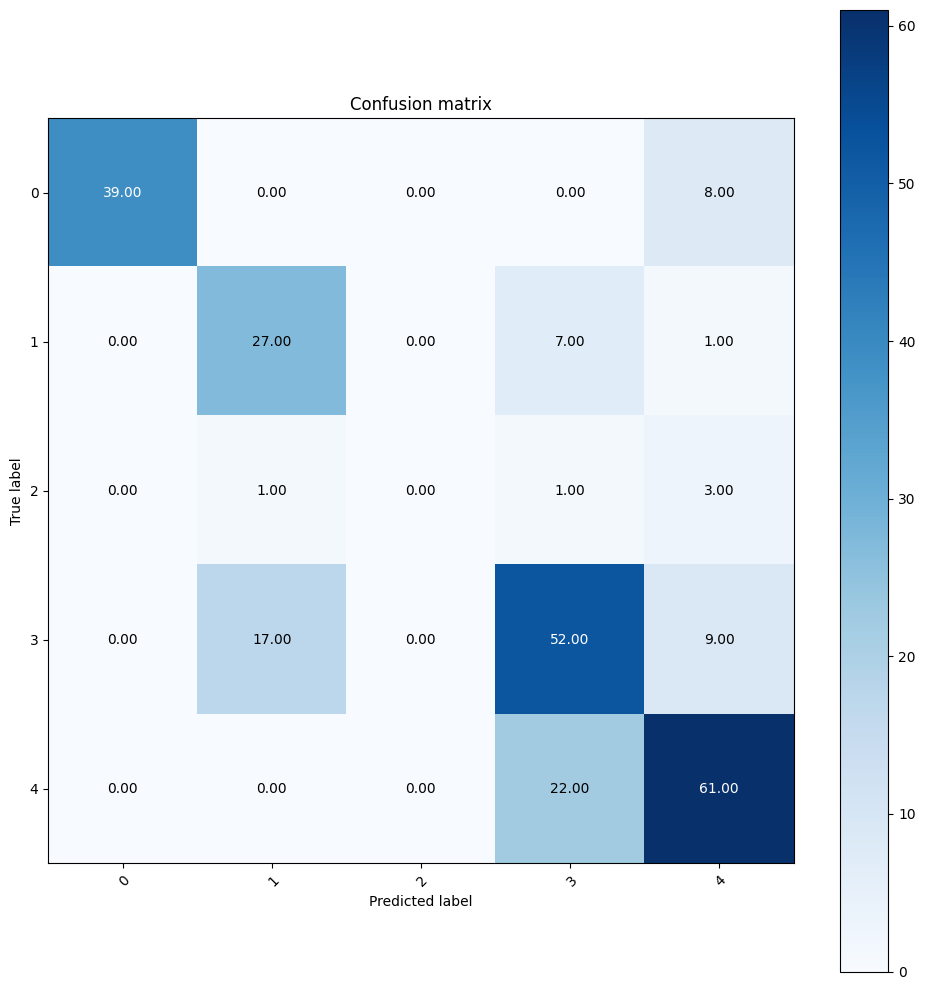

In [50]:
# Predict
y_pred = regressor.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

y_test_argmax = np.argmax(y_test, axis=1)
y_test_argmax = np.reshape(y_test_argmax, (y_test_argmax.shape[0],))

# Print predicted and actual values
for i in range(len(y_test_argmax)):
    print(f"Predicted: {y_pred_argmax[i]}; Actual: {y_test_argmax[i]}; Softmax: {y_pred[i]}")
#print("MSE: ", mean_squared_error(y_pred_argmax, y_test_argmax))
print("Accuracy: ", accuracy_score(y_pred_argmax, y_test_argmax))
# plt.plot(y_pred_argmax, label='Predicted')
# plt.plot(y_test_argmax, label='Actual')
# plt.legend()
# plt.show()

# Confusion matrix
print_confusion_matrix(y_test_argmax, y_pred_argmax)
#print("Accuracy: ", accuracy_score(y_test, y_pred))

Bag of sentences approach

In [179]:
embeddings_path = 'glove.840B.300d.txt'
with open(f'models/{embeddings_path}', 'r') as f:
    embeddings = {}
    lines = f.readlines()
    for line in tqdm.tqdm(lines):
        values = line.split()
        word = line.replace(" ".join(values[-300:]), "").strip()
        vector = np.asarray(values[-300:], dtype='float32')
        embeddings[word] = vector
    word_to_ix = {key: i for i, key in enumerate(embeddings.keys())}
    embeddings_tensor = torch.tensor(list(embeddings.values()))
    print("Loaded %s word vectors." % len(embeddings))

100%|██████████| 2196017/2196017 [01:11<00:00, 30736.43it/s]


Loaded 2195896 word vectors.


In [160]:
class BagOfSentencesModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, pretrained_embeddings):
        super(BagOfSentencesModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        #self.lstm1 = nn.LSTM(input_size, hidden_size)
        #self.lstm2 = nn.LSTM(hidden_size, hidden_size)
        #self.fc1 = nn.Linear(hidden_size, output_size * 10)
        #self.fc2 = nn.Linear(output_size * 10, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, sentences, argmax=False):
        sentence_embeddings = []
        for sentence in sentences:
            if not sentence: continue
            tokens = nltk.word_tokenize(sentence)
            tokens = [word for word in tokens if word in word_to_ix]
            word_indexes = torch.tensor([word_to_ix[word] for word in tokens], dtype=torch.long)
            embedded_sentence = self.embedding(word_indexes)
            # print(sentence)
            # print(tokens)
            # print(word_indexes)
            # print(embedded_sentence)
            _, (hidden_state, _) = self.lstm(embedded_sentence.view(len(word_indexes), 1, -1))
            #_, (hidden_state, _) = self.lstm2(hidden_state)
            sentence_embeddings.append(hidden_state[-1])
        h = torch.mean(torch.stack(sentence_embeddings), dim=0)
        r = self.fc(h)
        output = self.sigmoid(r)
        if argmax:
            return torch.argmax(output)
        return output

    def predict(self, sentences, argmax=False):
        with torch.no_grad():
            # return argmax
            return self.forward(sentences, argmax)
        
    def predict_transcripts(self, transcripts, argmax=False):
        results = [self.predict(transcript, argmax) for transcript in transcripts]
        results = torch.stack(results).squeeze()
        return results
        
    def forward_transcripts(self, transcripts, argmax=False):
        results = [self.forward(transcript, argmax) for transcript in transcripts]
        results = torch.stack(results).squeeze()
        return results
        
    def predict_proba(self, sentences):
        return self.predict(sentences)
    
    def score(self, sentences, labels):
        predictions = self.predict(sentences)
        return accuracy_score(labels, predictions)
    
    def fit(self, transcripts, labels, epochs=1000, batch_size=32, loss_threshold=0.001, loss_threshold_epochs=10):
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        prev_loss = 0
        sub_loss_threshold_epochs = loss_threshold_epochs
        for epoch in tqdm.tqdm(range(epochs)):
            for i in range(0, len(transcripts), batch_size):
                optimizer.zero_grad()
                batch_transcripts = transcripts[i:i+batch_size]
                batch_labels = labels[i:i+batch_size]
                predictions = self.forward_transcripts(batch_transcripts)
                batch_labels = torch.tensor(batch_labels, dtype=torch.float)
                # print(predictions, batch_labels)
                loss = criterion(predictions, batch_labels)
                loss.backward()
                optimizer.step()
                # Print statistics
                running_loss = loss.item()
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss))
                if abs(prev_loss - running_loss) < loss_threshold:
                    sub_loss_threshold_epochs -= 1
                    if sub_loss_threshold_epochs <= 0:
                        print("Loss threshold reached, stopping training.")
                        return self
                else:
                    sub_loss_threshold_epochs = loss_threshold_epochs
                prev_loss = running_loss
        return self
model = BagOfSentencesModel(300, 128, 5, embeddings_tensor)

In [161]:
len_train_transcripts = 30
train_transcripts = []
for transcript in data[:len_train_transcripts]['transcript']:
    train_transcripts.append([sentence['sentence'] for sentence in transcript])
train_labels = data[:len_train_transcripts]['popularity_category']

# Filter only the labels equal to 0 or 1
filtered_train_labels = []
filtered_train_transcripts = []
for l, t in zip(train_labels, train_transcripts):
    if l in [0, 1]:
        filtered_train_labels.append(l)
        filtered_train_transcripts.append(t)
train_labels = filtered_train_labels
train_transcripts = filtered_train_transcripts
print(len(train_labels), len(train_transcripts))

# Convert labels to one-hot vectors
train_labels = [label_to_one_hot(label, 5) for label in train_labels]
train_labels = torch.tensor(train_labels, dtype=torch.float32)


model.fit(train_transcripts, train_labels)

10 10


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/ks/8hgj6g0j5c5c88crmfrqcc_m0000gn/T/ipykernel_37260/4287664916.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels, dtype=torch.float)
  0%|          | 1/1000 [00:03<57:47,  3.47s/it]

[1,     1] loss: 0.871


  0%|          | 2/1000 [00:06<58:10,  3.50s/it]

[2,     1] loss: 0.863


  0%|          | 3/1000 [00:10<57:30,  3.46s/it]

[3,     1] loss: 0.855


  0%|          | 4/1000 [00:13<57:40,  3.47s/it]

[4,     1] loss: 0.848


  0%|          | 5/1000 [00:17<57:51,  3.49s/it]

[5,     1] loss: 0.840


  1%|          | 6/1000 [00:20<57:23,  3.46s/it]

[6,     1] loss: 0.831


  1%|          | 7/1000 [00:24<58:08,  3.51s/it]

[7,     1] loss: 0.822


  1%|          | 8/1000 [00:27<57:59,  3.51s/it]

[8,     1] loss: 0.812


  1%|          | 9/1000 [00:31<57:51,  3.50s/it]

[9,     1] loss: 0.801


  1%|          | 10/1000 [00:34<57:38,  3.49s/it]

[10,     1] loss: 0.790


  1%|          | 11/1000 [00:38<57:21,  3.48s/it]

[11,     1] loss: 0.778


  1%|          | 12/1000 [00:41<57:37,  3.50s/it]

[12,     1] loss: 0.765


  1%|▏         | 13/1000 [00:45<57:28,  3.49s/it]

[13,     1] loss: 0.753


  1%|▏         | 14/1000 [00:49<58:27,  3.56s/it]

[14,     1] loss: 0.743


  2%|▏         | 15/1000 [00:52<59:20,  3.61s/it]

[15,     1] loss: 0.734


  2%|▏         | 16/1000 [00:56<58:13,  3.55s/it]

[16,     1] loss: 0.726


  2%|▏         | 17/1000 [00:59<57:55,  3.54s/it]

[17,     1] loss: 0.720


  2%|▏         | 18/1000 [01:03<58:10,  3.55s/it]

[18,     1] loss: 0.715


  2%|▏         | 19/1000 [01:06<57:15,  3.50s/it]

[19,     1] loss: 0.711


  2%|▏         | 20/1000 [01:10<57:15,  3.51s/it]

[20,     1] loss: 0.708


  2%|▏         | 21/1000 [01:13<57:57,  3.55s/it]

[21,     1] loss: 0.705


  2%|▏         | 22/1000 [01:17<57:23,  3.52s/it]

[22,     1] loss: 0.703


  2%|▏         | 23/1000 [01:21<58:14,  3.58s/it]

[23,     1] loss: 0.702


  2%|▏         | 24/1000 [01:24<58:42,  3.61s/it]

[24,     1] loss: 0.700


  2%|▎         | 25/1000 [01:28<58:18,  3.59s/it]

[25,     1] loss: 0.699


  3%|▎         | 26/1000 [01:31<58:16,  3.59s/it]

[26,     1] loss: 0.698


  3%|▎         | 27/1000 [01:35<59:10,  3.65s/it]

[27,     1] loss: 0.698


  3%|▎         | 28/1000 [01:40<1:05:37,  4.05s/it]

[28,     1] loss: 0.697


  3%|▎         | 29/1000 [01:44<1:02:42,  3.87s/it]

[29,     1] loss: 0.697


  3%|▎         | 30/1000 [01:47<1:00:50,  3.76s/it]

[30,     1] loss: 0.696


  3%|▎         | 31/1000 [01:51<59:55,  3.71s/it]  

[31,     1] loss: 0.696


  3%|▎         | 32/1000 [01:54<59:00,  3.66s/it]

[32,     1] loss: 0.696


  3%|▎         | 33/1000 [01:58<59:07,  3.67s/it]

[33,     1] loss: 0.695


  3%|▎         | 34/1000 [02:01<57:48,  3.59s/it]

[34,     1] loss: 0.695


  3%|▎         | 34/1000 [02:05<59:20,  3.69s/it]

[35,     1] loss: 0.695
Loss threshold reached, stopping training.


BagOfSentencesModel(
  (embedding): Embedding(2195896, 300)
  (lstm): LSTM(300, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
len_train_transcripts = 30
train_transcripts = []
for transcript in data[:len_train_transcripts]['transcript']:
    train_transcripts.append([sentence['sentence'] for sentence in transcript])
train_labels = data[:len_train_transcripts]['popularity_category']

# Filter only the labels equal to 0 or 1
filtered_train_labels = []
filtered_train_transcripts = []
for l, t in zip(train_labels, train_transcripts):
    if l in [0, 1]:
        filtered_train_labels.append(l)
        filtered_train_transcripts.append(t)
train_labels = filtered_train_labels
train_transcripts = filtered_train_transcripts
print(len(train_labels), len(train_transcripts))

# Convert labels to one-hot vectors
train_labels = [label_to_one_hot(label, 5) for label in train_labels]
train_labels = torch.tensor(train_labels, dtype=torch.float32)


model.fit(train_transcripts, train_labels)

10 10


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/ks/8hgj6g0j5c5c88crmfrqcc_m0000gn/T/ipykernel_37260/4287664916.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = torch.tensor(batch_labels, dtype=torch.float)
  0%|          | 1/1000 [00:03<57:47,  3.47s/it]

[1,     1] loss: 0.871


  0%|          | 2/1000 [00:06<58:10,  3.50s/it]

[2,     1] loss: 0.863


  0%|          | 3/1000 [00:10<57:30,  3.46s/it]

[3,     1] loss: 0.855


  0%|          | 4/1000 [00:13<57:40,  3.47s/it]

[4,     1] loss: 0.848


  0%|          | 5/1000 [00:17<57:51,  3.49s/it]

[5,     1] loss: 0.840


  1%|          | 6/1000 [00:20<57:23,  3.46s/it]

[6,     1] loss: 0.831


  1%|          | 7/1000 [00:24<58:08,  3.51s/it]

[7,     1] loss: 0.822


  1%|          | 8/1000 [00:27<57:59,  3.51s/it]

[8,     1] loss: 0.812


  1%|          | 9/1000 [00:31<57:51,  3.50s/it]

[9,     1] loss: 0.801


  1%|          | 10/1000 [00:34<57:38,  3.49s/it]

[10,     1] loss: 0.790


  1%|          | 11/1000 [00:38<57:21,  3.48s/it]

[11,     1] loss: 0.778


  1%|          | 12/1000 [00:41<57:37,  3.50s/it]

[12,     1] loss: 0.765


  1%|▏         | 13/1000 [00:45<57:28,  3.49s/it]

[13,     1] loss: 0.753


  1%|▏         | 14/1000 [00:49<58:27,  3.56s/it]

[14,     1] loss: 0.743


  2%|▏         | 15/1000 [00:52<59:20,  3.61s/it]

[15,     1] loss: 0.734


  2%|▏         | 16/1000 [00:56<58:13,  3.55s/it]

[16,     1] loss: 0.726


  2%|▏         | 17/1000 [00:59<57:55,  3.54s/it]

[17,     1] loss: 0.720


  2%|▏         | 18/1000 [01:03<58:10,  3.55s/it]

[18,     1] loss: 0.715


  2%|▏         | 19/1000 [01:06<57:15,  3.50s/it]

[19,     1] loss: 0.711


  2%|▏         | 20/1000 [01:10<57:15,  3.51s/it]

[20,     1] loss: 0.708


  2%|▏         | 21/1000 [01:13<57:57,  3.55s/it]

[21,     1] loss: 0.705


  2%|▏         | 22/1000 [01:17<57:23,  3.52s/it]

[22,     1] loss: 0.703


  2%|▏         | 23/1000 [01:21<58:14,  3.58s/it]

[23,     1] loss: 0.702


  2%|▏         | 24/1000 [01:24<58:42,  3.61s/it]

[24,     1] loss: 0.700


  2%|▎         | 25/1000 [01:28<58:18,  3.59s/it]

[25,     1] loss: 0.699


  3%|▎         | 26/1000 [01:31<58:16,  3.59s/it]

[26,     1] loss: 0.698


  3%|▎         | 27/1000 [01:35<59:10,  3.65s/it]

[27,     1] loss: 0.698


  3%|▎         | 28/1000 [01:40<1:05:37,  4.05s/it]

[28,     1] loss: 0.697


  3%|▎         | 29/1000 [01:44<1:02:42,  3.87s/it]

[29,     1] loss: 0.697


  3%|▎         | 30/1000 [01:47<1:00:50,  3.76s/it]

[30,     1] loss: 0.696


  3%|▎         | 31/1000 [01:51<59:55,  3.71s/it]  

[31,     1] loss: 0.696


  3%|▎         | 32/1000 [01:54<59:00,  3.66s/it]

[32,     1] loss: 0.696


  3%|▎         | 33/1000 [01:58<59:07,  3.67s/it]

[33,     1] loss: 0.695


  3%|▎         | 34/1000 [02:01<57:48,  3.59s/it]

[34,     1] loss: 0.695


  3%|▎         | 34/1000 [02:05<59:20,  3.69s/it]

[35,     1] loss: 0.695
Loss threshold reached, stopping training.


BagOfSentencesModel(
  (embedding): Embedding(2195896, 300)
  (lstm): LSTM(300, 128)
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)

In [167]:
len_test_transcripts = 30
test_transcripts = []
for transcript in data[len_train_transcripts:len_train_transcripts+len_test_transcripts]['transcript']:
    test_transcripts.append([sentence['sentence'] for sentence in transcript])
test_labels = data[len_train_transcripts:len_train_transcripts+len_test_transcripts]['popularity_category']
# Filter only the labels equal to 0 or 1
filtered_test_labels = []
filtered_test_transcripts = []
for l, t in zip(test_labels, test_transcripts):
    if l in [0, 1]:
        filtered_test_labels.append(l)
        filtered_test_transcripts.append(t)
test_labels = filtered_test_labels
test_transcripts = filtered_test_transcripts
print(len(test_labels), len(test_transcripts))
# Convert labels to one-hot vectors
test_labels = [label_to_one_hot(label, 5) for label in test_labels]
test_labels = torch.tensor(test_labels, dtype=torch.float32)
#print(test_labels)
#print(list(word_to_ix.items())[:10])
print("Train predictions:")
predictions = model.predict_transcripts(train_transcripts)
for prediction, label in zip(predictions, train_labels):
    print(f"Predicted {one_hot_to_label(prediction)}, Actual {one_hot_to_label(label)}, softmax layer: {prediction}")

print("Test predictions:")
predictions = model.predict_transcripts(test_transcripts)
for prediction, label in zip(predictions, test_labels):
    print(f"Predicted {one_hot_to_label(prediction)}, Actual {one_hot_to_label(label)}, softmax layer: {prediction}")

print_confusion_matrix(test_labels, predictions)

8 8
Train predictions:


/var/folders/ks/8hgj6g0j5c5c88crmfrqcc_m0000gn/T/ipykernel_37260/4287664916.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  one_hot = torch.tensor(one_hot)


Predicted 1, Actual 1, softmax layer: tensor([0.0443, 0.0464, 0.0062, 0.0066, 0.0042])
Predicted 1, Actual 1, softmax layer: tensor([0.0461, 0.0473, 0.0065, 0.0068, 0.0044])
Predicted 1, Actual 1, softmax layer: tensor([0.0442, 0.0466, 0.0062, 0.0067, 0.0042])
Predicted 1, Actual 1, softmax layer: tensor([0.0466, 0.0470, 0.0064, 0.0069, 0.0044])
Predicted 0, Actual 0, softmax layer: tensor([0.0473, 0.0472, 0.0066, 0.0069, 0.0045])
Predicted 0, Actual 0, softmax layer: tensor([0.0458, 0.0455, 0.0061, 0.0066, 0.0042])
Predicted 1, Actual 1, softmax layer: tensor([0.0444, 0.0461, 0.0061, 0.0066, 0.0042])
Predicted 0, Actual 0, softmax layer: tensor([0.0483, 0.0449, 0.0063, 0.0067, 0.0043])
Predicted 0, Actual 0, softmax layer: tensor([0.0488, 0.0473, 0.0068, 0.0071, 0.0046])
Predicted 0, Actual 0, softmax layer: tensor([0.0479, 0.0468, 0.0067, 0.0069, 0.0045])
Test predictions:
Predicted 0, Actual 0, softmax layer: tensor([0.0465, 0.0435, 0.0060, 0.0063, 0.0041])
Predicted 0, Actual 0, so

In [168]:
import pickle
with open('models/model_1_0.pickle', 'wb') as f:
    f.write(pickle.dumps(model))
